In [1]:
import Pkg; Pkg.add("Rotations")

    Updating registry at `C:\Users\g.kirillov\.julia\registries\General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `C:\Users\g.kirillov\DDP\Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.7\Pkg\src\manifest.jl:287
  No Changes to `C:\Users\g.kirillov\DDP\Project.toml`
  No Changes to `C:\Users\g.kirillov\DDP\Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ C:\Users\g.kirillov\DDP\Manifest.toml:0


In [2]:
import Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `C:\Users\g.kirillov\DDP`


In [3]:
import Pkg; Pkg.precompile()

In [4]:
using Pkg
Pkg.build("MeshCat")

    Building WebIO ──→ `C:\Users\g.kirillov\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\0eef0765186f7452e52236fa42ca8c9b3c11c6e3\build.log`
    Building Blink ──→ `C:\Users\g.kirillov\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\08d0b679fd7caa49e2bca9214b131289e19808c0\build.log`
    Building MeshCat → `C:\Users\g.kirillov\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\ca4a1e45f5d2a2148c599804a6619da7708ede69\build.log`


In [5]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
import RobotDynamics as RD
using MatrixCalculus
using JLD2
using StaticArrays
using Rotations

In [6]:
#Acrobot Dynamics
a = RobotZoo.Quadrotor()
h = 0.05

0.05

In [7]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    x = SVector{13}(x)
    u = SVector{4}(u)
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)
    xn = SizedArray(x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
    xn[4:7] .= xn[4:7]/norm(xn[4:7])
    return xn
end

dynamics_rk4 (generic function with 1 method)

In [8]:
function dfdx(x,u)
    return ForwardDiff.jacobian(dx->dynamics_rk4(dx,u),x)
end

function dfdu(x,u)
    return ForwardDiff.jacobian(du->dynamics_rk4(x,du),u)
end

dfdu (generic function with 1 method)

In [9]:
function dAdx(x,u)
    ForwardDiff.jacobian(dx->vec(dfdx(dx,u)),x)
end

function dBdx(x,u)
    ForwardDiff.jacobian(dx->dfdu(dx,u),x)
end

function dAdu(x,u)
    ForwardDiff.jacobian(du->vec(dfdx(x,du)),u)
end

function dBdu(x,u)
    ForwardDiff.jacobian(du->dfdu(x,du),u)
end

dBdu (generic function with 1 method)

In [38]:
Nx = 13   # number of state
Nu = 4     # number of controls
Tfinal = 10.0 # final time
Teps = 0.6
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [66]:
# Cost weights
Q = Diagonal([1.0 * ones(7); 0.1 * ones(6)]);
Qi = Diagonal([100000.0 * ones(7); 0.01 * ones(6)])
Qline = Diagonal([100000.0; 0.01; 100000.0 * ones(5); 0.01 * ones(6)])
R = Array(0.1*I(Nu));
Qn = Array(1000.0*I(Nx));

In [67]:
Qline

13×13 Diagonal{Float64, Vector{Float64}}:
 100000.0   ⋅          ⋅         ⋅   …   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅   0.01        ⋅         ⋅       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅    100000.0        ⋅       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅   100000.0      ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅   …   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅      0.01   ⋅     ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅       ⋅    0.01   ⋅     ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅       ⋅     ⋅    0.01   ⋅     ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅   …   ⋅     ⋅     ⋅    0.01   ⋅     ⋅ 
       ⋅    ⋅          ⋅         ⋅       ⋅     ⋅     ⋅     ⋅    0.01   ⋅ 
       ⋅    ⋅          ⋅         ⋅       ⋅     ⋅     ⋅     ⋅     ⋅    

In [68]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5(u'*R*u)
end

stage_cost (generic function with 1 method)

In [69]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end
# посмотреть как делают остальные

terminal_cost (generic function with 1 method)

In [70]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k])
        # display(J)
    end
    J += terminal_cost(xtraj[:,Nt])
    
    return J
end

cost (generic function with 1 method)

In [71]:
function backward_pass!(p,P,d,K)
    xdes = xgoal
    Qs = Q
    ΔJ = 0.0
    p[:,Nt] .= Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] .= Qn
    
    for k = (Nt-1):-1:1
        #Calculate derivatives
        if thist[k] > Tinterm - Teps && thist[k] < Tinterm
            Qs = Qline
        elseif thist[k] == Tinterm
            Qs = Qi
            xdes = xinterm
        else 
            Qs = Q
        end
            
        q = Qs*(xtraj[:,k]-xdes)
        r = R*utraj[:, k]
        A = dfdx(xtraj[:,k], utraj[:,k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[:,k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
        
        # Ax = dAdx(xtraj[:,k], utraj[:,k])
        # Bx = dBdx(xtraj[:,k], utraj[:,k])
        # Au = dAdu(xtraj[:,k], utraj[:,k])
        # Bu = dBdu(xtraj[:,k], utraj[:,k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        #iLQR (Gauss-Newton) version
        Gxx = Qs + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
        
        #DDP (full Newton) version
        # Gxx = Q + A'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Ax
        # Guu = R + B'*P[:,:,k+1]*B + (kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bu)[1]
        # Gxu = A'*P[:,:,k+1]*B + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Au
        # Gux = B'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bx
        
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += A'*β*I*A
            Guu += B'*β*I*B
            Gxu += A'*β*I*B
            Gux += B'*β*I*A
            β = 2*β
            display("regularizing G")
            # display(β)
        end
        
        d[:,k] .= Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[:,k] - Gxu*d[:,k]
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[:,k]
    end
    
    return ΔJ
end

backward_pass! (generic function with 1 method)

In [72]:
#Initial guess
m=a.mass
g=9.81
uhover = SVector{4}((m*g/4)*ones(4))
x0 = ([1.0; 10.0; 2; 0.368871; -0.754934; 0.206149; -0.501509; 0; 0; 0; 0; 0; 0])
xinterm = SVector{13}([0.5; 5; 5; 0.707107; 0.0; 0.707107; 0.0; 0; 0; 0; 0; 0; 0])
Tinterm = 2.0

xgoal = SVector{13}([0.0; 0; 10; 1; 0; 0; 0; 0; 0; 0; 0; 0; 0])
xtraj = kron(ones(1,Nt), x0)
utraj = zeros(Nu, Nt-1) .+ uhover
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [73]:
QuatRotation(RotXYZ(0,pi/2, 0))

3×3 QuatRotation{Float64} with indices SOneTo(3)×SOneTo(3)(QuaternionF64(0.707107, 0.0, 0.707107, 0.0)):
  0.0  0.0  1.0
  0.0  1.0  0.0
 -1.0  0.0  0.0

In [74]:
?RobotZoo.Quadrotor

```
Quadrotor{R}
```

A standard quadrotor model, with simple aerodynamic forces. The orientation is represent by a general rotation `R`. The body z-axis point is vertical, so positive controls cause acceleration in the positive z direction.

# Constructor

```
Quadrotor(; kwargs...)
Quadrotor{R}(; kwargs...)
```

where `R <: Rotation{3}` and defaults to `UnitQuaternion{Float64}` if omitted. The keyword arguments are

  * `mass` - mass of the quadrotor, in kg (default = 0.5)
  * `J` - inertia of the quadrotor, in kg⋅m² (default = `Diagonal([0.0023, 0.0023, 0.004])`)
  * `gravity` - gravity vector, in kg/m² (default = [0,0,-9.81])
  * `motor_dist` - distane between the motors, in m (default = 0.1750)
  * `km` - motor torque constant (default = 0.0245)
  * `kf` - motor force constant (default = 1.0)


In [75]:
#Controlability Matrix
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->dynamics_rk4(x0,u),uhover);
C = B
for k = 1:(Nx-1)
    C = [C A*C[:,end-(Nu-1):end]]
end

In [76]:
rank(C)

12

In [77]:
xtraj[:,10]
utraj[:,10]

4-element Vector{Float64}:
 1.22625
 1.22625
 1.22625
 1.22625

In [78]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[:,k])
end
J = cost(xtraj,utraj)

3.25722863992172e8

In [79]:
#DDP Algorithm
p = ones(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nu,Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 1.0

xn = zeros(Nx,Nt)
un = zeros(Nu,Nt-1)

gx = zeros(Nx)
gu = zeros(Nu)
Gxx = zeros(Nx,Nx)
Guu = zeros(Nu)
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
Jp = 0
while abs(Jp-J) >  5 * 1e-5
    iter += 1    
    
    #Backward Pass
    ΔJ = backward_pass!(p,P,d,K)

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0
    
    # display(K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    # display(utraj[:,1] - α*d[:,1] - K[:,:,1] * (xn[:,1]-xtraj[:,1]))
    
    for k = 1:(Nt-1)
        # поменять разность между стейтами
        un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
    end
    Jn = cost(xn,un)
    # display(Jn)
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[:,k] .= utraj[:,k] - α*d[:,k] - K[:,:,k] * (xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[:,k])
        end
        Jn = cost(xn,un)
        # display(Jn)
    end
    Jp = J
    J = Jn
    xtraj .= xn
    utraj .= un
    display(J)
    # display(iter)
    # display(α)
    # display(maximum(abs.(d[:])))
    # display(xtraj[:, Nt])
end

1.832556755241223e8

1.0312921192633563e8

9.064211816632316e7

7.966692783240749e7

7.719695568238254e7

7.599553797435361e7

5.818578735198614e7

5.114041641628743e7

3.915463855418452e7

3.441360445448354e7

3.024668526839303e7

2.3158073521601457e7

2.035413970117395e7

1.5584471345575305e7

8.767068938756196e6

4.932793876926115e6

3.7773882110473528e6

2.8927789537983886e6

2.2228682886518347e6

1.7041887798077564e6

960442.5535196597

542276.479729908

306416.77180802496

173588.1364656355

98881.31620899976

26797.13854682064

2814.8796530770396

2814.8796530770396

In [80]:
iter

28

In [81]:
QuatRotation(RotXYZ(1,2,3))

3×3 QuatRotation{Float64} with indices SOneTo(3)×SOneTo(3)(QuaternionF64(0.368871, -0.754934, 0.206149, -0.501509)):
  0.411982   0.0587266   0.909297
 -0.681243  -0.642873    0.350175
  0.605127  -0.763718   -0.224845

In [82]:
J

2814.8796530770396

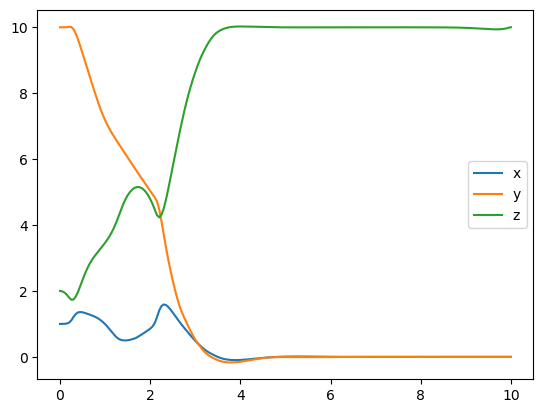

PyObject <matplotlib.legend.Legend object at 0x0000000001F57FB0>

In [83]:
plot(thist,xtraj[1,:], label="x")
plot(thist,xtraj[2,:], label="y")
plot(thist,xtraj[3,:], label="z")
legend()

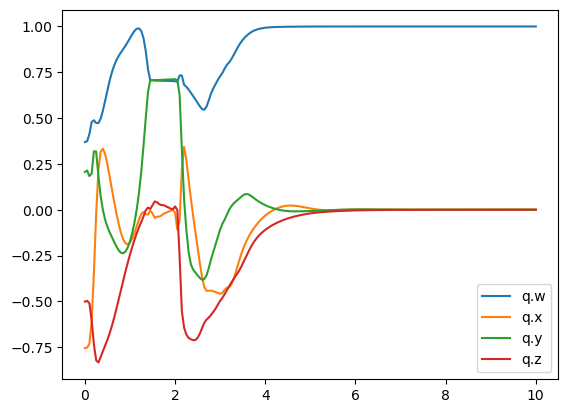

PyObject <matplotlib.legend.Legend object at 0x0000000001D31CA0>

In [84]:
plot(thist,xtraj[4,:], label="q.w")
plot(thist,xtraj[5,:], label="q.x")
plot(thist,xtraj[6,:], label="q.y")
plot(thist,xtraj[7,:], label="q.z")
legend()

LoadError: UndefVarError: R not defined

In [85]:
# проверить нормы кватернионов
for i in 1:Nt
    print("Norm: $(norm(xtraj[4:7, i])), Element number: $(i)\n")
end

Norm: 0.9999999231394969, Element number: 1
Norm: 1.0, Element number: 2
Norm: 1.0, Element number: 3
Norm: 1.0, Element number: 4
Norm: 1.0, Element number: 5
Norm: 0.9999999999999999, Element number: 6
Norm: 1.0, Element number: 7
Norm: 1.0, Element number: 8
Norm: 1.0, Element number: 9
Norm: 0.9999999999999999, Element number: 10
Norm: 0.9999999999999999, Element number: 11
Norm: 1.0, Element number: 12
Norm: 1.0, Element number: 13
Norm: 1.0, Element number: 14
Norm: 1.0, Element number: 15
Norm: 1.0, Element number: 16
Norm: 0.9999999999999999, Element number: 17
Norm: 1.0, Element number: 18
Norm: 0.9999999999999999, Element number: 19
Norm: 1.0, Element number: 20
Norm: 1.0, Element number: 21
Norm: 1.0, Element number: 22
Norm: 1.0, Element number: 23
Norm: 0.9999999999999999, Element number: 24
Norm: 0.9999999999999999, Element number: 25
Norm: 0.9999999999999998, Element number: 26
Norm: 0.9999999999999999, Element number: 27
Norm: 0.9999999999999999, Element number: 28
Norm

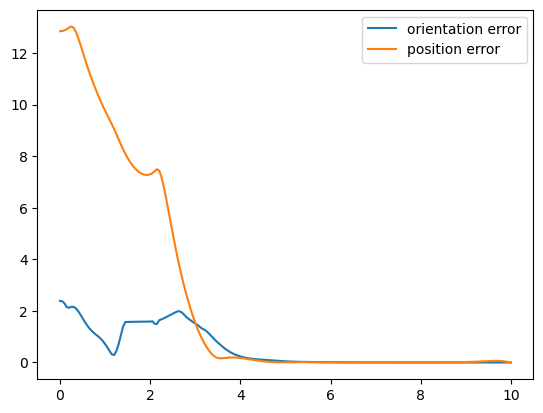

PyObject <matplotlib.legend.Legend object at 0x0000000001DAFA10>

In [86]:
# ошибку вычисляем с помощью матриц вращения, потом перевести в angleaxis. Вывести только угол ошибки
ang_errors = zeros(Nt)
pos_errors = zeros(Nt)
r_des = xgoal[1:3]
q_des = xgoal[4:7]
for i in 1:Nt
    x = xtraj[:, i]
    r = x[1:3]
    q = x[4:7]
    err_ang = QuatRotation(q_des) * QuatRotation(q)'
    ang_errors[i] = AngleAxis(QuatRotation(err_ang)).theta
    pos_errors[i] = norm(r-r_des)
end
plot(thist, ang_errors, label="orientation error")
plot(thist, pos_errors, label="position error")
legend()

In [87]:
# траектория с промежуточной точкой
# оживить эйелера

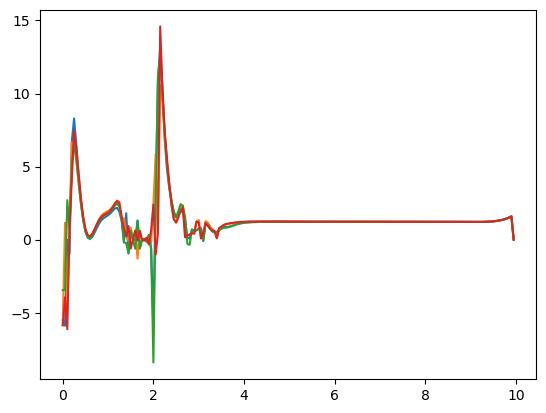

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000009D7D39E0>

In [88]:
plot(thist[1:Nt-1],utraj[1,:])
plot(thist[1:Nt-1],utraj[2,:])
plot(thist[1:Nt-1],utraj[3,:])
plot(thist[1:Nt-1],utraj[4,:])

In [89]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8702))

In [96]:
?RotXYZ

search: RotXYZ RotXYX RotXY RotXZY RotZXY RotYXY


```
struct RotXYZ{T} <: Rotation{3,T}
RotXYZ(theta1, theta2, theta3)
RotXYZ(roll=r, pitch=p, yaw=y)
```

A 3×3 rotation matrix parameterized by the "Tait-Bryant" XYZ Euler angle convention, consisting of first a rotation about the Z axis by `theta3`, followed by a rotation about the Y axis by `theta2`, and finally a rotation about the X axis by `theta1`.

The keyword argument form applies roll, pitch and yaw to the X, Y and Z axes respectively, in XYZ order. (Because it is a right-handed coordinate system, note that positive pitch is heading in the negative Z axis).


In [109]:
fieldnames(RotZYX)

(:theta1, :theta2, :theta3)

In [113]:
RotZYX(3,2,1) * [1,2,3]

3-element SVector{3, Float64} with indices SOneTo(3):
 -2.358384446657328
  1.7945828689699566
 -2.2841836896721697

In [90]:
TrajOptPlots.set_mesh!(vis, a)

false

In [91]:
function change_state_form(x)
    out = zeros(13)
    out[1:3] .= x[1:3]
    q = UnitQuaternion(RotXYZ(x[4], x[5], x[6]))
    out[4] = q.w
    out[5] = q.x
    out[6] = q.y
    out[7] = q.z
    out[8:13] .= x[7:12]
    return out
end

change_state_form (generic function with 1 method)

In [92]:
X1 = [SVector{13}(x) for x in eachcol(xtraj)];

visualize!(vis, a, thist[end], X1)